### __1. Extracting Historic weather data from API URL__

### 1.1 Daily weather data extraction (Containing sunrise and sunset daily data)

In [1]:
import requests
import csv
# Fetch data from the API
url = "https://archive-api.open-meteo.com/v1/archive?latitude=51.4552&longitude=-2.5966&start_date=2018-01-01&end_date=2023-06-06&daily=sunrise,sunset&timezone=Europe%2FLondon"
response = requests.get(url)
data = response.json()

# Prepare CSV file
csv_filename = "weather_data_DAILY.csv"

# Extract the required data from the JSON
dates = data["daily"]["time"]
sunrises = data["daily"]["sunrise"]
sunsets = data["daily"]["sunset"]

# Write data to CSV
with open(csv_filename, "w", newline="") as csv_file:
    writer = csv.writer(csv_file)

    # Write header
    writer.writerow(["Date", "Sunrise", "Sunset"])

    # Write daily data
    for date, sunrise, sunset in zip(dates, sunrises, sunsets):
        writer.writerow([date, sunrise, sunset])

print("Conversion completed. The data has been saved in", csv_filename)

Conversion completed. The data has been saved in weather_data_DAILY.csv


### 1.2 Hourly weather data extraction (Containing temperature, humidity and shortwave_radiation hourly data)

In [2]:
import requests
import csv

# API URL
url = "https://archive-api.open-meteo.com/v1/archive?latitude=51.4552&longitude=-2.5966&start_date=2018-01-01&end_date=2023-06-06&hourly=temperature_2m,relativehumidity_2m,shortwave_radiation&timezone=Europe%2FLondon"

# Send GET request to the API
response = requests.get(url)

# Check if the request was successful
if response.status_code == 200:
    data = response.json()

    # Extract relevant data from the response
    hourly_data = data["hourly"]
    column_names = ["time", "temperature_2m", "relativehumidity_2m", "shortwave_radiation"]

    # Write the data to a CSV file
    with open("weather_data_HOURLY.csv", "w", newline="") as file:
        writer = csv.writer(file)
        writer.writerow(column_names)
        for i in range(len(hourly_data["time"])):
            row = [hourly_data[column][i] for column in column_names]
            writer.writerow(row)
            
    print("CSV file created successfully.")
else:
    print("Failed to fetch data from the API.")

CSV file created successfully.


### __2. Historic weather data Cleaning and Analysis__

### 2.1 Weather Data

In [3]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [4]:
# Load the datasets (dates from 2018-01-01 until 2023-06-06)
weather_data_daily = pd.read_csv("weather_data_DAILY.csv")
weather_data_hourly = pd.read_csv("weather_data_HOURLY.csv")

In [5]:
# Rename the columns in weather_data_hourly
weather_data_hourly = weather_data_hourly.rename(columns={'temperature_2m': 'Temperature', 'relativehumidity_2m': 'Humidity', "shortwave_radiation": "Shortwave_Radiation"})

In [6]:
# Convert 'time' column in hourly dataset to datetime
weather_data_hourly['time'] = pd.to_datetime(weather_data_hourly['time'])
weather_data_daily['Date'] = pd.to_datetime(weather_data_daily['Date'])

### 2.2 Converting the Hourly weather data into Daily weather data calculating the mean of the variables and merged it

In [7]:
# Group hourly data by date and calculate mean
hourly_data_mean = weather_data_hourly.groupby(weather_data_hourly['time'].dt.date).mean()

# Reset index to make date a column
hourly_data_mean = hourly_data_mean.reset_index()

# Convert 'Date' column in daily data to datetime
weather_data_daily['Date'] = pd.to_datetime(weather_data_daily['Date'])

# Merge hourly mean data with daily data based on date
merged_data = weather_data_daily.merge(hourly_data_mean, left_on=weather_data_daily['Date'].dt.date, right_on=hourly_data_mean['time'], how='left')

# Drop unnecessary columns from the merged data
merged_data.drop(['key_0', 'time'], axis=1, inplace=True)

# Calculate hours of sunlight per day
merged_data['Sunrise'] = pd.to_datetime(merged_data['Sunrise'])
merged_data['Sunset'] = pd.to_datetime(merged_data['Sunset'])
merged_data['Sunlight_hours'] = (merged_data['Sunset'] - merged_data['Sunrise']).dt.total_seconds() / 3600

# Print the merged data
print(merged_data)

           Date             Sunrise              Sunset  Temperature  \
0    2018-01-01 2018-01-01 09:15:00 2018-01-01 17:12:00     6.383333   
1    2018-01-02 2018-01-02 09:15:00 2018-01-02 17:13:00     7.375000   
2    2018-01-03 2018-01-03 09:15:00 2018-01-03 17:14:00     8.233333   
3    2018-01-04 2018-01-04 09:15:00 2018-01-04 17:15:00     8.004167   
4    2018-01-05 2018-01-05 09:14:00 2018-01-05 17:16:00     5.279167   
...         ...                 ...                 ...          ...   
1978 2023-06-02 2023-06-02 04:58:00 2023-06-02 21:18:00    13.195833   
1979 2023-06-03 2023-06-03 04:57:00 2023-06-03 21:19:00    14.091667   
1980 2023-06-04 2023-06-04 04:57:00 2023-06-04 21:20:00    15.275000   
1981 2023-06-05 2023-06-05 04:56:00 2023-06-05 21:21:00    13.758333   
1982 2023-06-06 2023-06-06 04:55:00 2023-06-06 21:22:00    13.237500   

       Humidity  Shortwave_Radiation  Sunlight_hours  
0     81.708333            30.333333        7.950000  
1     86.500000          

In [15]:
merged_data

,Date,Sunrise,Sunset,Temperature,Humidity,Shortwave_Radiation,Sunlight_hours
0,2018-01-01,2018-01-01 09:15:00,2018-01-01 17:12:00,6.383333,81.708333,30.333333,7.950000
1,2018-01-02,2018-01-02 09:15:00,2018-01-02 17:13:00,7.375000,86.500000,8.916667,7.966667
2,2018-01-03,2018-01-03 09:15:00,2018-01-03 17:14:00,8.233333,70.750000,40.958333,7.983333
3,2018-01-04,2018-01-04 09:15:00,2018-01-04 17:15:00,8.004167,82.500000,25.000000,8.000000
4,2018-01-05,2018-01-05 09:14:00,2018-01-05 17:16:00,5.279167,88.250000,36.083333,8.033333
...,...,...,...,...,...,...,...
1978,2023-06-02,2023-06-02 04:58:00,2023-06-02 21:18:00,13.195833,65.375000,301.166667,16.333333
1979,2023-06-03,2023-06-03 04:57:00,2023-06-03 21:19:00,14.091667,68.791667,323.791667,16.366667
1980,2023-06-04,2023-06-04 04:57:00,2023-06-04 21:20:00,15.275000,66.083333,342.250000,16.383333
1981,2023-06-05,2023-06-05 04:56:00,2023-06-05 21:21:00,13.758333,70.375000,333.000000,16.416667


In [16]:
# From all the variables of the historic weather data, the most important ones were selected
selected_columns = ["Temperature", "Humidity", "Shortwave_Radiation", "Date", "Sunlight_hours"]
new_weather_df = merged_data[selected_columns]

In [17]:
new_weather_df

,Temperature,Humidity,Shortwave_Radiation,Date,Sunlight_hours
0,6.383333,81.708333,30.333333,2018-01-01,7.950000
1,7.375000,86.500000,8.916667,2018-01-02,7.966667
2,8.233333,70.750000,40.958333,2018-01-03,7.983333
3,8.004167,82.500000,25.000000,2018-01-04,8.000000
4,5.279167,88.250000,36.083333,2018-01-05,8.033333
...,...,...,...,...,...
1978,13.195833,65.375000,301.166667,2023-06-02,16.333333
1979,14.091667,68.791667,323.791667,2023-06-03,16.366667
1980,15.275000,66.083333,342.250000,2023-06-04,16.383333
1981,13.758333,70.375000,333.000000,2023-06-05,16.416667


### __3. Extracting the Solar Generation Data__

In [18]:
# Historic solar consumption data from 2018-01-01 to 2023-06-06
solar_df1 = pd.read_csv("Full(1).csv")

In [19]:
solar_df1["Time"] = pd.to_datetime(solar_df1["Time"])

### __4. Merge the weather and solar datasets__

In [20]:
# Merged the historic weather data with the solar generation consumption data
merged_df = pd.merge(new_weather_df, solar_df1, left_on='Date', right_on='Time')

In [22]:
# Convert "Temperature" and "Humidity" to integers
merged_df["Temperature"] = merged_df["Temperature"].astype(int)
merged_df["Humidity"] = merged_df["Humidity"].astype(int)

# Convert "Shortwave_Radiation" and "Sunlight_hours" to floats with two decimal places
merged_df["Shortwave_Radiation"] = merged_df["Shortwave_Radiation"].round(2)
merged_df["Sunlight_hours"] = merged_df["Sunlight_hours"].round(2)

In [23]:
merged_df

,Temperature,Humidity,Shortwave_Radiation,Date,Sunlight_hours,Time,gen
0,6,81,30.33,2018-01-01,7.95,2018-01-01,23.362676
1,7,86,8.92,2018-01-02,7.97,2018-01-02,18.812548
2,8,70,40.96,2018-01-03,7.98,2018-01-03,29.057803
3,8,82,25.00,2018-01-04,8.00,2018-01-04,22.020129
4,5,88,36.08,2018-01-05,8.03,2018-01-05,29.631941
...,...,...,...,...,...,...,...
1978,13,65,301.17,2023-06-02,16.33,2023-06-02,97.246218
1979,14,68,323.79,2023-06-03,16.37,2023-06-03,121.742163
1980,15,66,342.25,2023-06-04,16.38,2023-06-04,120.950493
1981,13,70,333.00,2023-06-05,16.42,2023-06-05,68.336305


### __5. Calculate the correlations__

In [24]:
# Calculate the correlation matrix
correlation_matrix = merged_df.corr()
# Print the correlation matrix
print(correlation_matrix)

                     Temperature  Humidity  Shortwave_Radiation  \
Temperature             1.000000 -0.407553             0.576301   
Humidity               -0.407553  1.000000            -0.772725   
Shortwave_Radiation     0.576301 -0.772725             1.000000   
Sunlight_hours          0.697812 -0.595304             0.825120   
gen                     0.549054 -0.666227             0.841948   

                     Sunlight_hours       gen  
Temperature                0.697812  0.549054  
Humidity                  -0.595304 -0.666227  
Shortwave_Radiation        0.825120  0.841948  
Sunlight_hours             1.000000  0.788099  
gen                        0.788099  1.000000  


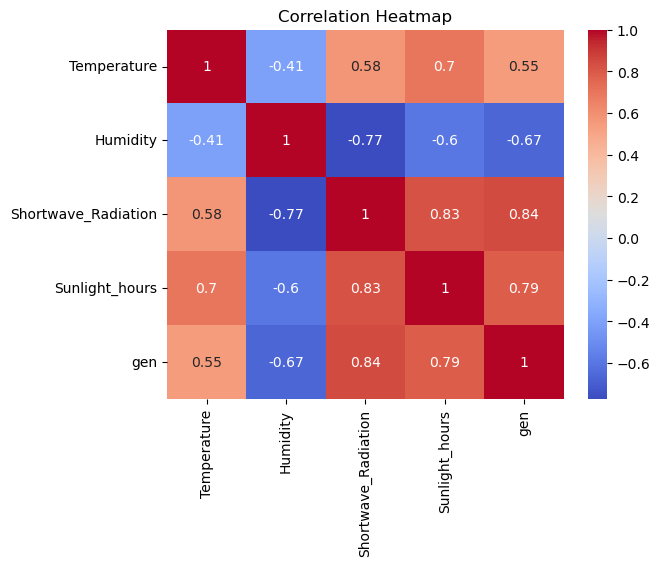

In [25]:
# Create a heatmap using seaborn
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm')
# Set the title of the plot
plt.title('Correlation Heatmap')
# Display the plot
plt.show()

### 5.1 Statistical Analysis (p-value)

In [26]:
import scipy.stats as stats
# Calculate the Pearson correlation coefficient and the p-value for Shortwave_Radiation vs Gen
r, p = stats.pearsonr(merged_df['gen'], merged_df['Shortwave_Radiation'])
print('Analysis of Shortwave_Radiation vs Gen')
print('---------------------------------------------')
print('The Pearson correlation coefficient is:', round(r, 3))
print('The p-value is: {:.10f}'.format(p))
print()
# Calculate the Pearson correlation coefficient and the p-value for Shortwave_Radiation vs Gen
r, p = stats.pearsonr(merged_df['gen'], merged_df['Sunlight_hours'])
print('Analysis of Sunlight_hours vs Gen')
print('---------------------------------------------')
print('The Pearson correlation coefficient is:', round(r, 3))
print('The p-value is: {:.10f}'.format(p))
print()
# Calculate the Pearson correlation coefficient and the p-value for humidity vs Gen
r, p = stats.pearsonr(merged_df['gen'], merged_df['Humidity'])
print('Analysis of Humidity vs Gen')
print('---------------------------------------------')
print('The Pearson correlation coefficient is:', round(r, 3))
print('The p-value is: {:.10f}'.format(p))
print()
# Calculate the Pearson correlation coefficient and the p-value for Temperature vs Gen
r, p = stats.pearsonr(merged_df['gen'], merged_df['Temperature'])
print('Analysis of Temperature vs Gen')
print('---------------------------------------------')
print('The Pearson correlation coefficient is:', round(r, 3))
print('The p-value is: {:.10f}'.format(p))

Analysis of Shortwave_Radiation vs Gen
---------------------------------------------
The Pearson correlation coefficient is: 0.842
The p-value is: 0.0000000000

Analysis of Sunlight_hours vs Gen
---------------------------------------------
The Pearson correlation coefficient is: 0.788
The p-value is: 0.0000000000

Analysis of Humidity vs Gen
---------------------------------------------
The Pearson correlation coefficient is: -0.666
The p-value is: 0.0000000000

Analysis of Temperature vs Gen
---------------------------------------------
The Pearson correlation coefficient is: 0.549
The p-value is: 0.0000000000


### __Interpretation__
1. Shortwave Radiation: There is a positive correlation of __0.84__ between shortwave radiation and solar panel generation. This correlation implies that as shortwave radiation increases, the generation of solar panels also tends to increase.

2. Sunlight Hours: There is a positive correlation of __0.79__ between sunlight hours and solar panel generation. This suggests that as the number of sunlight hours increases, the generation of solar panels tends to increase as well.

3. Humidity: There is a negative correlation of __-0.67__ between humidity and solar panel generation. This indicates that as humidity increases, the generation of solar panels tends to decrease.


4. Temperature: There is a positive correlation of __0.55__ between temperature and solar panel generation. This suggests that as temperature increases, the generation of solar panels also tends to increase.